In [1]:
from IPython.display import HTML
HTML('''
    <style> body {font-family: "Roboto Condensed Light", "Roboto Condensed";} h2 {padding: 10px 12px; background-color: #E64626; position: static; color: #ffffff; font-size: 40px;} .text_cell_render p { font-size: 15px; } .text_cell_render h1 { font-size: 30px; } h1 {padding: 10px 12px; background-color: #E64626; color: #ffffff; font-size: 40px;} .text_cell_render h3 { padding: 10px 12px; background-color: #0148A4; position: static; color: #ffffff; font-size: 20px;} h4:before{ 
    content: "@"; font-family:"Wingdings"; font-style:regular; margin-right: 4px;} .text_cell_render h4 {padding: 8px; font-family: "Roboto Condensed Light"; position: static; font-style: italic; background-color: #FFB800; color: #ffffff; font-size: 18px; text-align: center; border-radius: 5px;}input[type=submit] {background-color: #E64626; border: solid; border-color: #734036; color: white; padding: 8px 16px; text-decoration: none; margin: 4px 2px; cursor: pointer; border-radius: 20px;}</style>
''')
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt

In [2]:
# Connecting to Database
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json

credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

In [3]:
db, conn = pgconnect(credentials)

Connected successfully.


In [4]:
srid = 4283
# Function that converts to WKT element
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

sa2 = gpd.read_file("SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp")
sa2 = sa2.dropna()

sa2og = sa2.copy()  # creating a copy of the original for later
sa2['geom'] = sa2['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
sa2 = sa2.drop(columns="geometry")
sa2 = sa2.drop(columns="AUS_NAME21")
sa2 = sa2.drop(columns="AUS_CODE21")
sa2= sa2.query("GCC_NAME21 == 'Greater Sydney'") # FILTERING FOR GREATER SYDNEY
sa2 = sa2.drop(columns=["LOCI_URI21", "GCC_NAME21", "GCC_CODE21"])# Dropping unwanted coloumns

sa2

,SA2_CODE21,SA2_NAME21,CHG_FLAG21,CHG_LBL21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,STE_CODE21,STE_NAME21,AREASQKM21,geom
28,102011028,Avoca Beach - Copacabana,0,No change,10201,Gosford,102,Central Coast,1,New South Wales,6.4376,MULTIPOLYGON (((151.413733024921 -33.465580583...
29,102011029,Box Head - MacMasters Beach,0,No change,10201,Gosford,102,Central Coast,1,New South Wales,32.0802,MULTIPOLYGON (((151.37484081570685 -33.5005199...
30,102011030,Calga - Kulnura,0,No change,10201,Gosford,102,Central Coast,1,New South Wales,767.9512,MULTIPOLYGON (((151.20449037540152 -33.5328022...
31,102011031,Erina - Green Point,0,No change,10201,Gosford,102,Central Coast,1,New South Wales,33.7934,MULTIPOLYGON (((151.37193611462118 -33.4369790...
32,102011032,Gosford - Springfield,0,No change,10201,Gosford,102,Central Coast,1,New South Wales,16.9123,MULTIPOLYGON (((151.32348639265098 -33.4277852...
...,...,...,...,...,...,...,...,...,...,...,...,...
637,128021537,Royal National Park,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1,New South Wales,139.3336,MULTIPOLYGON (((151.07362997413264 -34.0563789...
638,128021538,Sutherland - Kirrawee,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1,New South Wales,7.7550,MULTIPOLYGON (((151.05006441218998 -34.0215774...
639,128021607,Engadine,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1,New South Wales,8.9538,MULTIPOLYGON (((150.99568346574816 -34.0536082...
640,128021608,Loftus - Yarrawarrah,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1,New South Wales,3.8436,MULTIPOLYGON (((151.03954821100714 -34.0417452...


<Axes: >

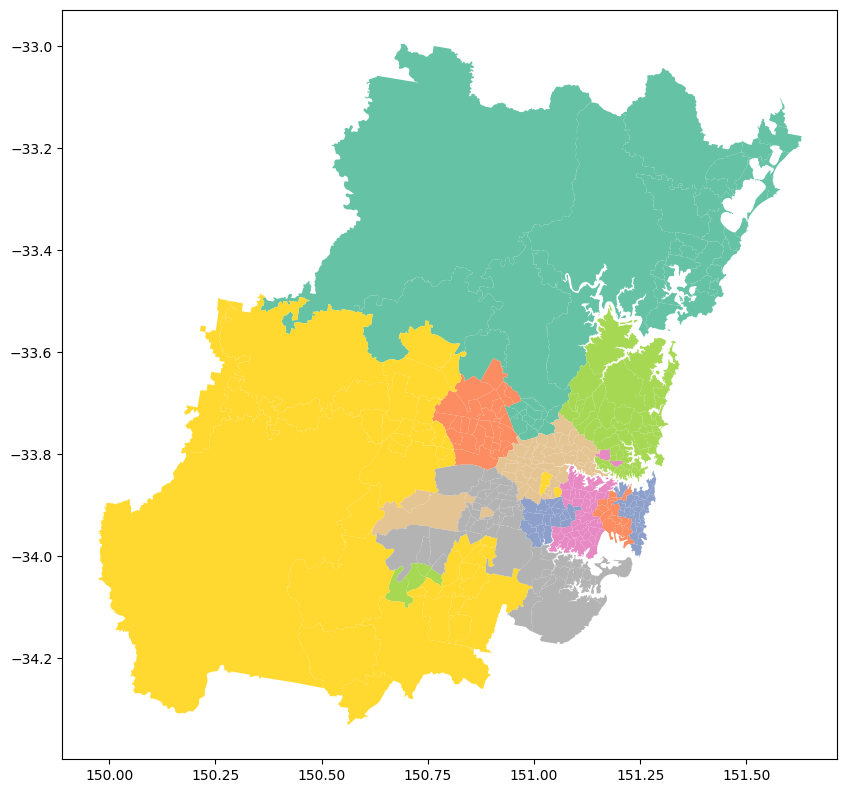

In [5]:
# Map of the Greater Sydney Area according to the SA2 file
greater_sydney = sa2og[(sa2og['GCC_NAME21']=='Greater Sydney')]
greater_sydney.plot(cmap='Set2', figsize=(10, 10))

In [6]:
catchp = gpd.read_file("catchments/catchments_primary.shp")

catchpog = catchp.copy()  # creating a copy of the original for later
catchp['geom'] = catchp['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
catchp = catchp.drop(columns=[ "PRIORITY","geometry" ]) # Removing unwanted coloumns
catchp

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,geom
0,2838,PRIMARY,Parklea PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,MULTIPOLYGON (((150.93563850416004 -33.7161211...
1,2404,PRIMARY,Lindfield EPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,MULTIPOLYGON (((151.1833640465581 -33.74748398...
2,4393,PRIMARY,Carlingford WPS,20220223,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,MULTIPOLYGON (((151.0451821055135 -33.77303212...
3,4615,PRIMARY,Caddies Ck PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,MULTIPOLYGON (((150.92567327976582 -33.7296030...
4,3918,PRIMARY,Killara PS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,MULTIPOLYGON (((151.1537883781186 -33.75586174...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657,4383,PRIMARY,E A Southee PS,20200315,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,MULTIPOLYGON (((147.9462089946497 -34.55863148...
1658,3275,PRIMARY,Tumbarumba PS,20200507,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,MULTIPOLYGON (((148.12885348977485 -35.6008184...
1659,2239,PRIMARY,Jindera PS,20200507,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,MULTIPOLYGON (((146.86147943204122 -35.8751106...
1660,3594,PRIMARY,Louth PS,20200604,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,MULTIPOLYGON (((145.18402754685187 -29.6580498...


In [7]:
catchs = gpd.read_file("catchments/catchments_secondary.shp")

catchsog = catchs.copy()  # creating a copy of the original for later
catchs['geom'] = catchs['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
catchs = catchs.drop(columns=["geometry", "PRIORITY"])  # deleting unwanted coloumns
catchs

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,geom
0,8503,HIGH_COED,Billabong HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,MULTIPOLYGON (((146.67182402032344 -35.3144375...
1,8266,HIGH_COED,James Fallon HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,MULTIPOLYGON (((147.08733806259178 -35.8627146...
2,8505,HIGH_COED,Murray HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,MULTIPOLYGON (((146.81447829547324 -35.7834062...
3,8458,HIGH_COED,Kingswood HS,20201016,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,MULTIPOLYGON (((150.68599834118749 -33.7403060...
4,8559,HIGH_COED,Jamison HS,20201016,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,MULTIPOLYGON (((150.69513440644116 -33.7562688...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,8213,HIGH_BOYS,Birrong BHS,20211221,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,MULTIPOLYGON (((151.05363508494244 -33.8507612...
432,8108,HIGH_COED,Cessnock HS,20230405,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,MULTIPOLYGON (((151.4285214252146 -32.74415247...
433,3235,CENTRAL_HIGH,Tooleybuc CS,20200512,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,MULTIPOLYGON (((143.37723402388323 -34.8017260...
434,1115,CENTRAL_HIGH,Balranald CS,20200512,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,MULTIPOLYGON (((143.65540852703225 -33.5570248...


In [8]:
catchf = gpd.read_file("catchments/catchments_future.shp")

catchfog = catchf.copy()  # creating a copy of the original for later
catchf['geom'] = catchf['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
catchf = catchf.drop(columns="geometry")  # deleting unwanted coloumns
catchf

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,geom
0,8416,HIGH_COED,Ku-ring-gai HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,MULTIPOLYGON (((151.19848917708944 -33.5398987...
1,8161,HIGH_BOYS,Randwick BHS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,MULTIPOLYGON (((151.27151530428182 -33.9140183...
2,8539,HIGH_COED,SSC Blackwattle Bay,20220609,0,0,0,0,0,0,0,0,0,0,0,2024,2024,MULTIPOLYGON (((151.15292370935092 -33.8393921...
3,8400,HIGH_COED,St Ives HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,MULTIPOLYGON (((151.17793729938725 -33.6982001...
4,8555,HIGH_COED,Rose Bay SC,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,MULTIPOLYGON (((151.28072275958445 -33.8328728...
5,8556,CENTRAL_HIGH,Alexandria Park CS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,MULTIPOLYGON (((151.1949653506184 -33.88876468...
6,8913,HIGH_COED,Inner Sydney HS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2025,MULTIPOLYGON (((151.2098245099502 -33.85422949...
7,8286,HIGH_COED,Mt Annan HS,20220301,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,MULTIPOLYGON (((150.77298245154256 -34.0251624...
8,8584,HIGH_COED,Elizabeth Macarthur HS,20220301,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,MULTIPOLYGON (((150.7323512413543 -34.01465804...
9,8290,HIGH_COED,John Edmondson HS,20190520,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,MULTIPOLYGON (((150.70497435250746 -33.9042617...


In [9]:
population = pd.read_csv("population.csv")
population.rename(columns = {'0-4_people':'zero_4_people','5-9_people':'five_9_people','10-14_people':'ten_14_people',
                             '15-19_people':'fifteen_19_people','20-24_people':'twenty_24_people','25-29_people':'twenty_five_29_people',
                             '30-34_people':'thirty_34_people','35-39_people':'thirty_five_39_people','40-44_people':'fourty_44_people',
                             '45-49_people':'fourty_five_49_people','50-54_people':'fifty_54_people','55-59_people':'fifty_five_59_people',
                             '60-64_people':'sixty_64_people','65-69_people':'sixty_five_69_people','70-74_people':'seventy_74_people','75-79_people':'seventy_five_79_people',
                             '80-84_people':'eighty_84_people','85-and-over_people':'eighty_five_and_over_people'}, inplace = True)
population

,sa2_code,sa2_name,zero_4_people,five_9_people,ten_14_people,fifteen_19_people,twenty_24_people,twenty_five_29_people,thirty_34_people,thirty_five_39_people,...,fourty_five_49_people,fifty_54_people,fifty_five_59_people,sixty_64_people,sixty_five_69_people,seventy_74_people,seventy_five_79_people,eighty_84_people,eighty_five_and_over_people,total_people
0,102011028,Avoca Beach - Copacabana,424,522,623,552,386,222,306,416,...,572,602,570,520,464,369,226,142,70,7530
1,102011029,Box Head - MacMasters Beach,511,666,702,592,461,347,420,535,...,749,749,794,895,863,925,603,331,264,11052
2,102011030,Calga - Kulnura,200,225,258,278,274,227,214,286,...,325,436,422,397,327,264,190,100,75,4748
3,102011031,Erina - Green Point,683,804,880,838,661,502,587,757,...,859,882,901,930,917,1065,976,773,1028,14803
4,102011032,Gosford - Springfield,1164,1044,1084,1072,1499,1864,1750,1520,...,1330,1241,1377,1285,1166,949,664,476,537,21346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,128021537,Royal National Park,2,4,10,4,9,7,1,2,...,4,0,0,0,1,0,0,0,0,45
369,128021538,Sutherland - Kirrawee,1519,1292,1150,1117,1335,1852,2120,1945,...,1569,1391,1285,1157,909,909,781,582,807,23369
370,128021607,Engadine,1157,1283,1469,1209,891,675,928,1229,...,1315,1086,909,764,707,886,748,389,327,17379
371,128021608,Loftus - Yarrawarrah,503,487,575,508,380,293,426,493,...,564,477,450,387,418,335,263,192,109,7354


In [10]:
income = pd.read_csv("income.csv")
income = income.drop(income[income['median_age'] == 'np'].index)
income

,sa2_code,sa2_name,earners,median_age,median_income,mean_income
0,101021007,Braidwood,2426,50,44246,61745
1,101021008,Karabar,5128,42,62946,67345
2,101021009,Queanbeyan,6778,39,61724,67276
3,101021010,Queanbeyan - East,3360,40,64010,71770
4,101021011,Queanbeyan Region,13502,44,74042,85303
...,...,...,...,...,...,...
571,128021537,Royal National Park,13,36,38956,61645
572,128021538,Sutherland - Kirrawee,13698,41,62453,71105
573,128021607,Engadine,10335,43,60914,70158
574,128021608,Loftus - Yarrawarrah,4498,45,60469,73218


In [11]:
business = pd.read_csv("businesses.csv")
business.rename(columns = {'0_to_50k_businesses':'zero_to_50k_businesses', '50k_to_200k_businesses':'fifty_to_200k_businesses',
                           '200k_to_2m_businesses':'twohundred_to_2m_businesses','2m_to_5m_businesses':'twomillion_to_5m_businesses',
                          '5m_to_10m_businesses':'fivemillion_to_10m_businesses','10m_or_more_businesses':'tenmillion_or_more_businesses'}, inplace = True)

business

,industry_code,industry_name,sa2_code,sa2_name,zero_to_50k_businesses,fifty_to_200k_businesses,twohundred_to_2m_businesses,twomillion_to_5m_businesses,fivemillion_to_10m_businesses,tenmillion_or_more_businesses,total_businesses
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,136,92,63,4,0,0,296
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,6,3,0,0,0,0,9
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,6,4,3,0,0,3,15
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,0,3,0,0,0,0,3
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,7,4,5,0,0,0,16
...,...,...,...,...,...,...,...,...,...,...,...
12212,S,Other Services,128021538,Sutherland - Kirrawee,21,66,58,3,3,0,152
12213,S,Other Services,128021607,Engadine,13,41,31,3,0,0,87
12214,S,Other Services,128021608,Loftus - Yarrawarrah,0,10,10,0,0,0,22
12215,S,Other Services,128021609,Woronora Heights,0,3,5,0,0,0,9


In [12]:
#Converting latitude and longtitude into a geom coloumn with points and converting to POSTGIS format
srid = 4283
stops = pd.read_csv("stops.txt")
stops['geom'] = gpd.points_from_xy(stops.stop_lon, stops.stop_lat)  # creating the geometry column
stops = stops.drop(columns=['stop_lat', 'stop_lon'])  # removing the old latitude/longitude fields
stops['geom'] = stops['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))
stops


,stop_id,stop_code,stop_name,location_type,parent_station,wheelchair_boarding,platform_code,geom
0,200039,200039.0,"Central Station, Eddy Av, Stand A",NaN,200060,0,NaN,POINT (151.20666465471 -33.8822064874687)
1,200054,200054.0,"Central Station, Eddy Av, Stand D",NaN,200060,0,NaN,POINT (151.20699145565 -33.8820421431408)
2,200060,NaN,Central Station,1.0,NaN,0,NaN,POINT (151.206292455081 -33.8840842535493)
3,201510,NaN,Redfern Station,1.0,NaN,0,NaN,POINT (151.198866071817 -33.8916900512711)
4,201646,201646.0,"Redfern Station, Gibbons St, Stand B",NaN,201510,0,NaN,POINT (151.198881722942 -33.8933293130144)
...,...,...,...,...,...,...,...,...
114713,212753,212753.0,"Sydney Olympic Park Wharf, Side B",NaN,21271,1,B,POINT (151.07879697831 -33.8220164586429)
114714,2137185,2137185.0,"Cabarita Wharf, Side A",NaN,21371,1,1A,POINT (151.116926480557 -33.8406690716775)
114715,2137186,2137186.0,"Cabarita Wharf, Side B",NaN,21371,1,1B,POINT (151.116898892402 -33.8407691073139)
114716,21501,21501.0,Parramatta Wharf,NaN,2150112,1,NaN,POINT (151.010576673346 -33.8139042429414)


In [13]:
polling = pd.read_csv("pollingplaces2019.csv")
polling = polling.drop(columns = "the_geom")
polling['the_geom'] = gpd.points_from_xy(polling.longitude, polling.latitude) # Creating our own geom using lat and long
polling['the_geom'] = polling['the_geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))
polling = polling.drop(columns = ["premises_address_1", "premises_address_2", "premises_address_3", "latitude", "longitude"])
polling

,FID,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_suburb,premises_state_abbreviation,premises_post_code,the_geom
0,aec_federal_election_polling_places_2019.fid-4...,NSW,104,Barton,33595,2,Special Hospital Team 1,Multiple sites,NaN,NSW,NaN,POINT EMPTY
1,aec_federal_election_polling_places_2019.fid-4...,NSW,105,Bennelong,33596,2,Special Hospital Team 1,Multiple sites,NaN,NSW,NaN,POINT EMPTY
2,aec_federal_election_polling_places_2019.fid-4...,NSW,107,Blaxland,33600,2,Special Hospital Team 1,Multiple sites,NaN,NSW,NaN,POINT EMPTY
3,aec_federal_election_polling_places_2019.fid-4...,NSW,109,Calare,33603,2,Special Hospital Team 1,Multiple sites,ORANGE,NSW,2800.0,POINT EMPTY
4,aec_federal_election_polling_places_2019.fid-4...,NSW,113,Cowper,33716,2,Special Hospital Team 2,Multiple sites,NaN,NSW,NaN,POINT EMPTY
...,...,...,...,...,...,...,...,...,...,...,...,...
2925,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,2809,1,Warilla South,Warilla High School,BARRACK HEIGHTS,NSW,2528.0,POINT (150.858 -34.5642)
2926,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,58798,5,Warilla WHITLAM PPVC,2/144 Shellharbour Rd,WARILLA,NSW,2528.0,POINT (150.8597546 -34.5508228)
2927,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,31242,1,Welby,Welby Community Hall,WELBY,NSW,2575.0,POINT (150.424 -34.4409)
2928,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,564,1,Windang,Windang Public School,WINDANG,NSW,2528.0,POINT (150.866 -34.5316)


### Loading Spatial Data

Populate tables in our database, firstly by defining schemas for each

In [14]:
conn.execute("""
DROP TABLE IF EXISTS sa2 CASCADE;
CREATE TABLE sa2 (
    "SA2_CODE21" INTEGER PRIMARY KEY, 
    "SA2_NAME21" VARCHAR(100),
    "CHG_FLAG21" INTEGER,
    "CHG_LBL21" VARCHAR(50),
    "SA3_CODE21" INTEGER,
    "SA3_NAME21" VARCHAR(100),
    "SA4_CODE21" INTEGER,
    "SA4_NAME21" VARCHAR(100),
    "STE_CODE21" INTEGER,
    "STE_NAME21" VARCHAR(50), 
    "AREASQKM21" NUMERIC,
    geom GEOMETRY(MULTIPOLYGON,4283)
);"""
)    
conn.execute("""
DROP TABLE IF EXISTS catchp;
CREATE TABLE catchp (
    "USE_ID" INTEGER PRIMARY KEY, 
    "CATCH_TYPE" VARCHAR(100),
    "USE_DESC" VARCHAR(100),
    "ADD_DATE" INTEGER,
    "KINDERGART" CHAR(1),
    "YEAR1" CHAR(1),
    "YEAR2" CHAR(1),
    "YEAR3" CHAR(1),
    "YEAR4" CHAR(1),
    "YEAR5" CHAR(1),
    "YEAR6" CHAR(1),
    "YEAR7" CHAR(1),
    "YEAR8" CHAR(1),
    "YEAR9" CHAR(1),
    "YEAR10" CHAR(1),
    "YEAR11" CHAR(1),
    "YEAR12" CHAR(1),
    geom GEOMETRY(MULTIPOLYGON,4283)
);"""
) 
conn.execute("""
DROP TABLE IF EXISTS catchs;
CREATE TABLE catchs (
    "USE_ID" INTEGER PRIMARY KEY, 
    "CATCH_TYPE" VARCHAR(100),
    "USE_DESC" VARCHAR(100),
    "ADD_DATE" INTEGER,
    "KINDERGART" CHAR(1),
    "YEAR1" CHAR(1),
    "YEAR2" CHAR(1),
    "YEAR3" CHAR(1),
    "YEAR4" CHAR(1),
    "YEAR5" CHAR(1),
    "YEAR6" CHAR(1),
    "YEAR7" CHAR(1),
    "YEAR8" CHAR(1),
    "YEAR9" CHAR(1),
    "YEAR10" CHAR(1),
    "YEAR11" CHAR(1),
    "YEAR12" CHAR(1),
    geom GEOMETRY(MULTIPOLYGON,4283)
);"""
) 
conn.execute("""
DROP TABLE IF EXISTS catchf;
CREATE TABLE catchf (
    "USE_ID" INTEGER PRIMARY KEY, 
    "CATCH_TYPE" VARCHAR(100),
    "USE_DESC" VARCHAR(100),
    "ADD_DATE" INTEGER,
    "KINDERGART" INTEGER,
    "YEAR1" INTEGER,
    "YEAR2" INTEGER,
    "YEAR3" INTEGER,
    "YEAR4" INTEGER,
    "YEAR5" INTEGER,
    "YEAR6" INTEGER,
    "YEAR7" INTEGER,
    "YEAR8" INTEGER,
    "YEAR9" INTEGER,
    "YEAR10" INTEGER,
    "YEAR11" INTEGER,
    "YEAR12" INTEGER,
    geom GEOMETRY(MULTIPOLYGON,4283)
);"""
) 
conn.execute("""
DROP TABLE IF EXISTS polling;
CREATE TABLE polling (
    "FID" VARCHAR(100) , 
    state VARCHAR(10), 
    division_id INTEGER,
    division_name VARCHAR(80),
    polling_place_id INTEGER Primary Key,
    polling_place_type_id INTEGER,
    polling_place_name VARCHAR(100),
    premises_name VARCHAR(100),
    premises_suburb VARCHAR(100),
    premises_state_abbreviation VARCHAR(10),
    premises_post_code NUMERIC,
    the_geom GEOMETRY(POINT,4283)
);"""
)

conn.execute("""
DROP TABLE IF EXISTS stops;
CREATE TABLE stops (
    stop_id VARCHAR(10) PRIMARY KEY,
    stop_code NUMERIC, 
    stop_name VARCHAR(100),
    location_type NUMERIC,
    parent_station VARCHAR(10),
    wheelchair_boarding NUMERIC,
    platform_code VARCHAR(80),
    geom GEOMETRY(POINT,4283)
);"""
)

conn.execute("""
DROP TABLE IF EXISTS business;
CREATE TABLE business (
    industry_code CHAR,
    industry_name VARCHAR(100),
    sa2_code INTEGER,
    sa2_name VARCHAR(100),
    zero_to_50k_businesses INTEGER, 
    fifty_to_200k_businesses INTEGER,
    twohundred_to_2m_businesses INTEGER,
    twomillion_to_5m_businesses INTEGER,
    fivemillion_to_10m_businesses INTEGER,
    tenmillion_or_more_businesses INTEGER,
    total_businesses INTEGER,
    PRIMARY KEY (industry_code, sa2_code)
    
);"""
)

conn.execute("""
DROP TABLE IF EXISTS income;
CREATE TABLE income (
    sa2_code INTEGER PRIMARY KEY,
    sa2_name VARCHAR(100),
    earners INTEGER,
    median_age NUMERIC, 
    median_income NUMERIC,
    mean_income NUMERIC
    
);"""
)

conn.execute("""
DROP TABLE IF EXISTS population;
CREATE TABLE population (
    sa2_code INTEGER PRIMARY KEY,
    sa2_name VARCHAR(100),
    zero_4_people INTEGER,
    five_9_people INTEGER,
    ten_14_people INTEGER,
    fifteen_19_people INTEGER,
    twenty_24_people INTEGER,
    twenty_five_29_people INTEGER,
    thirty_34_people INTEGER,
    thirty_five_39_people INTEGER,
    fourty_44_people INTEGER,
    fourty_five_49_people INTEGER,
    fifty_54_people INTEGER,
    fifty_five_59_people INTEGER,
    sixty_64_people INTEGER,
    sixty_five_69_people INTEGER,
    seventy_74_people INTEGER,
    seventy_five_79_people INTEGER,
    eighty_84_people INTEGER,
    eighty_five_and_over_people INTEGER,
    total_people INTEGER,
    FOREIGN KEY (sa2_code) REFERENCES sa2("SA2_CODE21") 
);"""
)
conn.execute(""" DROP INDEX IF EXISTS population_index;
CREATE INDEX population_index
ON population(total_people);
""")
conn.execute(""" DROP INDEX IF EXISTS sa2_geom_index;
CREATE INDEX sa2_geom_index
ON sa2
USING gist(geom);
""")

In [15]:
sa2.to_sql('sa2', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, """select * from sa2   """ )

,SA2_CODE21,SA2_NAME21,CHG_FLAG21,CHG_LBL21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,STE_CODE21,STE_NAME21,AREASQKM21,geom
0,102011028,Avoca Beach - Copacabana,0,No change,10201,Gosford,102,Central Coast,1,New South Wales,6.4376,0106000020BB100000010000000103000000010000005E...
1,102011029,Box Head - MacMasters Beach,0,No change,10201,Gosford,102,Central Coast,1,New South Wales,32.0802,0106000020BB1000000100000001030000000100000010...
2,102011030,Calga - Kulnura,0,No change,10201,Gosford,102,Central Coast,1,New South Wales,767.9512,0106000020BB1000000200000001030000000100000085...
3,102011031,Erina - Green Point,0,No change,10201,Gosford,102,Central Coast,1,New South Wales,33.7934,0106000020BB1000000100000001030000000100000041...
4,102011032,Gosford - Springfield,0,No change,10201,Gosford,102,Central Coast,1,New South Wales,16.9123,0106000020BB100000010000000103000000010000007E...
...,...,...,...,...,...,...,...,...,...,...,...,...
368,128021537,Royal National Park,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1,New South Wales,139.3336,0106000020BB1000000100000001030000000100000046...
369,128021538,Sutherland - Kirrawee,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1,New South Wales,7.7550,0106000020BB1000000100000001030000000100000089...
370,128021607,Engadine,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1,New South Wales,8.9538,0106000020BB100000010000000103000000010000008E...
371,128021608,Loftus - Yarrawarrah,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1,New South Wales,3.8436,0106000020BB10000001000000010300000001000000A1...


In [16]:
catchp.to_sql('catchp', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, """select * from catchp """)

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,geom
0,2838,PRIMARY,Parklea PS,20181210.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,0106000020BB1000000100000001030000000100000078...
1,2404,PRIMARY,Lindfield EPS,20211219.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,0106000020BB10000001000000010300000001000000BE...
2,4393,PRIMARY,Carlingford WPS,20220223.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,0106000020BB1000000100000001030000000100000065...
3,1659,PRIMARY,Corowa SPS,20200404.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,0106000020BB1000000100000001030000000100000007...
4,1455,PRIMARY,Burwood PS,20211221.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,0106000020BB1000000100000001030000000100000030...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657,2409,PRIMARY,Lismore SPS,20200616.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,0106000020BB10000001000000010300000001000000C9...
1658,4383,PRIMARY,E A Southee PS,20200315.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,0106000020BB10000001000000010300000001000000B9...
1659,3275,PRIMARY,Tumbarumba PS,20200507.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,0106000020BB10000001000000010300000001000000C0...
1660,2239,PRIMARY,Jindera PS,20200507.0,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,0106000020BB10000001000000010300000001000000F6...


In [17]:
catchs.to_sql('catchs', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, """select * from catchs """)

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,geom
0,8503,HIGH_COED,Billabong HS,20200507.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,0106000020BB100000010000000103000000010000006D...
1,8266,HIGH_COED,James Fallon HS,20200507.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,0106000020BB1000000100000001030000000100000071...
2,8559,HIGH_COED,Jamison HS,20201016.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,0106000020BB100000010000000103000000020000002F...
3,8502,HIGH_COED,Tomaree HS,20211115.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,0106000020BB100000010000000103000000010000003B...
4,8505,HIGH_COED,Murray HS,20200507.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,0106000020BB100000010000000103000000010000003F...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,8213,HIGH_BOYS,Birrong BHS,20211221.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,0106000020BB1000000100000001030000000100000040...
432,8108,HIGH_COED,Cessnock HS,20230405.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,0106000020BB10000001000000010300000001000000AD...
433,3235,CENTRAL_HIGH,Tooleybuc CS,20200512.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,0106000020BB100000010000000103000000010000003E...
434,1115,CENTRAL_HIGH,Balranald CS,20200512.0,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,0106000020BB100000010000000103000000010000005B...


In [18]:
catchf.to_sql('catchf', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, """select * from catchf """)

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,geom
0,8416,HIGH_COED,Ku-ring-gai HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,0106000020BB1000000100000001030000000100000090...
1,8161,HIGH_BOYS,Randwick BHS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,0106000020BB100000010000000103000000010000006F...
2,8539,HIGH_COED,SSC Blackwattle Bay,20220609,0,0,0,0,0,0,0,0,0,0,0,2024,2024,0106000020BB10000001000000010300000001000000E3...
3,8286,HIGH_COED,Mt Annan HS,20220301,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,0106000020BB1000000100000001030000000100000099...
4,8400,HIGH_COED,St Ives HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,0106000020BB1000000100000001030000000100000060...
5,8555,HIGH_COED,Rose Bay SC,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,0106000020BB100000010000000103000000010000000C...
6,8556,CENTRAL_HIGH,Alexandria Park CS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,0106000020BB1000000100000001030000000100000028...
7,8584,HIGH_COED,Elizabeth Macarthur HS,20220301,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,0106000020BB10000001000000010300000001000000BB...
8,8913,HIGH_COED,Inner Sydney HS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2025,0106000020BB1000000100000001030000000100000076...
9,8135,HIGH_COED,Parramatta HS,20230112,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,0106000020BB100000010000000103000000010000001F...


In [19]:
polling.to_sql('polling', conn, if_exists='append', index=False, dtype={'the_geom': Geometry('POINT', srid)})
query(conn, "select * from polling")

,FID,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_suburb,premises_state_abbreviation,premises_post_code,the_geom
0,aec_federal_election_polling_places_2019.fid-4...,NSW,104,Barton,33595,2,Special Hospital Team 1,Multiple sites,None,NSW,NaN,0101000020BB100000000000000000F87F000000000000...
1,aec_federal_election_polling_places_2019.fid-4...,NSW,105,Bennelong,33596,2,Special Hospital Team 1,Multiple sites,None,NSW,NaN,0101000020BB100000000000000000F87F000000000000...
2,aec_federal_election_polling_places_2019.fid-4...,NSW,107,Blaxland,33600,2,Special Hospital Team 1,Multiple sites,None,NSW,NaN,0101000020BB100000000000000000F87F000000000000...
3,aec_federal_election_polling_places_2019.fid-4...,NSW,109,Calare,33603,2,Special Hospital Team 1,Multiple sites,ORANGE,NSW,2800.0,0101000020BB100000000000000000F87F000000000000...
4,aec_federal_election_polling_places_2019.fid-4...,NSW,113,Cowper,33716,2,Special Hospital Team 2,Multiple sites,None,NSW,NaN,0101000020BB100000000000000000F87F000000000000...
...,...,...,...,...,...,...,...,...,...,...,...,...
2925,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,2809,1,Warilla South,Warilla High School,BARRACK HEIGHTS,NSW,2528.0,0101000020BB100000FA7E6ABC74DB62409C33A2B43748...
2926,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,58798,5,Warilla WHITLAM PPVC,2/144 Shellharbour Rd,WARILLA,NSW,2528.0,0101000020BB100000BD32141C83DB624011F28B5C8146...
2927,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,31242,1,Welby,Welby Community Hall,WELBY,NSW,2575.0,0101000020BB10000021B0726891CD6240386744696F38...
2928,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,564,1,Windang,Windang Public School,WINDANG,NSW,2528.0,0101000020BB100000C1CAA145B6DB6240DC4603780B44...


In [20]:
stops.to_sql('stops', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from stops")

,stop_id,stop_code,stop_name,location_type,parent_station,wheelchair_boarding,platform_code,geom
0,200039,200039.0,"Central Station, Eddy Av, Stand A",NaN,200060,0.0,None,0101000020BB100000FFA631FF9CE66240A1FF6524ECF0...
1,200054,200054.0,"Central Station, Eddy Av, Stand D",NaN,200060,0.0,None,0101000020BB1000002F928BAC9FE66240E33DC7C1E6F0...
2,200060,NaN,Central Station,1.0,None,0.0,None,0101000020BB100000817FA2F299E662408FF33DAC29F1...
3,201510,NaN,Redfern Station,1.0,None,0.0,None,0101000020BB1000009E57611C5DE6624060304CE622F2...
4,201646,201646.0,"Redfern Station, Gibbons St, Stand B",NaN,201510,0.0,None,0101000020BB100000DBF9333D5DE662403DFA6B9D58F2...
...,...,...,...,...,...,...,...,...
114713,212753,212753.0,"Sydney Olympic Park Wharf, Side B",NaN,21271,1.0,B,0101000020BB100000AF9B3D8185E262408F52D7D537E9...
114714,2137185,2137185.0,"Cabarita Wharf, Side A",NaN,21371,1.0,1A,0101000020BB100000EB409ADCBDE3624089CE4C0B9BEB...
114715,2137186,2137186.0,"Cabarita Wharf, Side B",NaN,21371,1.0,1B,0101000020BB100000C4F9BEA2BDE362403EB375529EEB...
114716,21501,21501.0,Parramatta Wharf,NaN,2150112,1.0,None,0101000020BB100000E443E4A456E0624025C1A4032EE8...


In [21]:
business.to_sql('business', conn, if_exists='append', index=False)
query(conn, "select * from business")

,industry_code,industry_name,sa2_code,sa2_name,zero_to_50k_businesses,fifty_to_200k_businesses,twohundred_to_2m_businesses,twomillion_to_5m_businesses,fivemillion_to_10m_businesses,tenmillion_or_more_businesses,total_businesses
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,136,92,63,4,0,0,296
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,6,3,0,0,0,0,9
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,6,4,3,0,0,3,15
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,0,3,0,0,0,0,3
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,7,4,5,0,0,0,16
...,...,...,...,...,...,...,...,...,...,...,...
12212,S,Other Services,128021538,Sutherland - Kirrawee,21,66,58,3,3,0,152
12213,S,Other Services,128021607,Engadine,13,41,31,3,0,0,87
12214,S,Other Services,128021608,Loftus - Yarrawarrah,0,10,10,0,0,0,22
12215,S,Other Services,128021609,Woronora Heights,0,3,5,0,0,0,9


In [22]:

income.to_sql('income', conn, if_exists='append', index=False)
query(conn, "select * from income")

,sa2_code,sa2_name,earners,median_age,median_income,mean_income
0,101021007,Braidwood,2426,50.0,44246.0,61745.0
1,101021008,Karabar,5128,42.0,62946.0,67345.0
2,101021009,Queanbeyan,6778,39.0,61724.0,67276.0
3,101021010,Queanbeyan - East,3360,40.0,64010.0,71770.0
4,101021011,Queanbeyan Region,13502,44.0,74042.0,85303.0
...,...,...,...,...,...,...
565,128021537,Royal National Park,13,36.0,38956.0,61645.0
566,128021538,Sutherland - Kirrawee,13698,41.0,62453.0,71105.0
567,128021607,Engadine,10335,43.0,60914.0,70158.0
568,128021608,Loftus - Yarrawarrah,4498,45.0,60469.0,73218.0


In [23]:
population.to_sql('population', conn, if_exists='append', index=False)
query(conn, "select * from population")

,sa2_code,sa2_name,zero_4_people,five_9_people,ten_14_people,fifteen_19_people,twenty_24_people,twenty_five_29_people,thirty_34_people,thirty_five_39_people,...,fourty_five_49_people,fifty_54_people,fifty_five_59_people,sixty_64_people,sixty_five_69_people,seventy_74_people,seventy_five_79_people,eighty_84_people,eighty_five_and_over_people,total_people
0,102011028,Avoca Beach - Copacabana,424,522,623,552,386,222,306,416,...,572,602,570,520,464,369,226,142,70,7530
1,102011029,Box Head - MacMasters Beach,511,666,702,592,461,347,420,535,...,749,749,794,895,863,925,603,331,264,11052
2,102011030,Calga - Kulnura,200,225,258,278,274,227,214,286,...,325,436,422,397,327,264,190,100,75,4748
3,102011031,Erina - Green Point,683,804,880,838,661,502,587,757,...,859,882,901,930,917,1065,976,773,1028,14803
4,102011032,Gosford - Springfield,1164,1044,1084,1072,1499,1864,1750,1520,...,1330,1241,1377,1285,1166,949,664,476,537,21346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,128021537,Royal National Park,2,4,10,4,9,7,1,2,...,4,0,0,0,1,0,0,0,0,45
369,128021538,Sutherland - Kirrawee,1519,1292,1150,1117,1335,1852,2120,1945,...,1569,1391,1285,1157,909,909,781,582,807,23369
370,128021607,Engadine,1157,1283,1469,1209,891,675,928,1229,...,1315,1086,909,764,707,886,748,389,327,17379
371,128021608,Loftus - Yarrawarrah,503,487,575,508,380,293,426,493,...,564,477,450,387,418,335,263,192,109,7354


## Question 2 

1. Get the mean value for all the variables 

Retail business/1000 people

In [24]:
sql = """
SELECT distinct S."SA2_CODE21", industry_name, B.total_businesses, total_people
FROM business B JOIN sa2 S ON (B.sa2_code = S."SA2_CODE21" ) JOIN population P ON (P.sa2_code = S."SA2_CODE21" )
WHERE B.industry_code = 'G' and total_people >= 100
ORDER By total_people
"""

query(conn, sql)

,SA2_CODE21,industry_name,total_businesses,total_people
0,117011320,Retail Trade,36,507
1,119011355,Retail Trade,71,1480
2,115031299,Retail Trade,14,2854
3,128011605,Retail Trade,17,3371
4,102021049,Retail Trade,13,3428
...,...,...,...,...
355,116021563,Retail Trade,91,24870
356,124031462,Retail Trade,80,24882
357,116021632,Retail Trade,124,25314
358,119031374,Retail Trade,165,25399


In [25]:
sql = """
DROP VIEW IF EXISTS retail CASCADE;
CREATE VIEW retail AS
SELECT distinct S."SA2_CODE21", industry_name, B.total_businesses, total_people, (CAST(B.total_businesses as float)/CAST(total_people as float))*1000 as "business/1000"
FROM business B JOIN sa2 S ON (B.sa2_code = S."SA2_CODE21" ) JOIN population P ON (P.sa2_code = S."SA2_CODE21" )
WHERE B.industry_code = 'G' and total_people >= 100
"""
query(conn, sql)
sql2 = """

SELECT *
FROM retail
order by total_businesses
"""
query(conn, sql2)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,SA2_CODE21,industry_name,total_businesses,total_people,business/1000
0,128021609,Retail Trade,9,3551,2.534497
1,102021049,Retail Trade,13,3428,3.792299
2,102011035,Retail Trade,13,7191,1.807815
3,115031299,Retail Trade,14,2854,4.905396
4,128011605,Retail Trade,17,3371,5.043014
...,...,...,...,...,...
355,122031429,Retail Trade,299,22009,13.585351
356,121011684,Retail Trade,338,19770,17.096611
357,117031336,Retail Trade,343,16053,21.366723
358,117031645,Retail Trade,472,20346,23.198663


In [26]:
sql = """
DROP VIEW IF EXISTS retail_stats;
CREATE VIEW retail_stats AS
SELECT  avg("business/1000"), stddev("business/1000")
FROM retail
"""

query(conn, sql)
sql2 = """
SELECT *
FROM retail_stats
"""

query(conn, sql2)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,avg,stddev
0,7.394895,9.553617


In [27]:
sql = """
DROP VIEW IF EXISTS retail_z_score;
CREATE VIEW retail_z_score AS
SELECT distinct B.sa2_code, "SA2_NAME21",((total_businesses-avg)/stddev) as z_score
FROM business B JOIN sa2 S ON (B.sa2_code = S."SA2_CODE21" ) JOIN population P ON (P.sa2_code = S."SA2_CODE21" ), retail_stats
WHERE B.industry_code = 'G' and total_people >= 100
order by B.sa2_code
"""

sql2 = """
SELECT *
from retail_z_score
"""
query(conn, sql)
query(conn, sql2)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,sa2_code,SA2_NAME21,z_score
0,102011028,Avoca Beach - Copacabana,3.936217
1,102011029,Box Head - MacMasters Beach,4.459579
2,102011030,Calga - Kulnura,5.192285
3,102011031,Erina - Green Point,15.136163
4,102011032,Gosford - Springfield,18.066990
...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,9.169837
356,128021538,Sutherland - Kirrawee,12.205336
357,128021607,Engadine,6.343682
358,128021608,Loftus - Yarrawarrah,2.261458


### Z-Score for Health 

In [28]:
sql = """
DROP VIEW IF EXISTS health CASCADE;
CREATE VIEW health AS
SELECT distinct S."SA2_CODE21", industry_name, B.total_businesses, total_people, (CAST(B.total_businesses as float)/CAST(total_people as float))*1000 as "business/1000"
FROM business B JOIN sa2 S ON (B.sa2_code = S."SA2_CODE21" ) JOIN population P ON (P.sa2_code = S."SA2_CODE21" )
WHERE B.industry_code = 'Q' and total_people >= 100
"""
query(conn, sql)
sql2 = """

SELECT *
FROM health
order by total_businesses
"""
query(conn, sql2)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,SA2_CODE21,industry_name,total_businesses,total_people,business/1000
0,115031299,Health Care and Social Assistance,3,2854,1.051156
1,117011320,Health Care and Social Assistance,3,507,5.917160
2,124031465,Health Care and Social Assistance,6,6053,0.991244
3,127011726,Health Care and Social Assistance,12,4774,2.513615
4,124041468,Health Care and Social Assistance,13,7564,1.718667
...,...,...,...,...,...
355,121031407,Health Care and Social Assistance,383,22592,16.952904
356,121011684,Health Care and Social Assistance,513,19770,25.948407
357,118011341,Health Care and Social Assistance,532,17866,29.777230
358,115011291,Health Care and Social Assistance,675,21792,30.974670


In [29]:
sql = """
DROP VIEW IF EXISTS health_stats;
CREATE VIEW health_stats AS
SELECT  avg("business/1000"), stddev("business/1000")
FROM health
"""

query(conn, sql)
sql2 = """
SELECT *
FROM health_stats
"""

query(conn, sql2)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,avg,stddev
0,8.081094,8.148192


In [30]:
sql = """
DROP VIEW IF EXISTS health_z_score;
CREATE VIEW health_z_score AS
SELECT distinct B.sa2_code,  "SA2_NAME21", ((total_businesses-avg)/stddev) as z_score
FROM business B JOIN sa2 S ON (B.sa2_code = S."SA2_CODE21" ) JOIN population P ON (P.sa2_code = S."SA2_CODE21" ), health_stats
WHERE B.industry_code = 'Q' and total_people >= 100
order by B.sa2_code
"""

sql2 = """ 
SELECT *
FROM health_z_score"""
query(conn, sql)
query(conn, sql2)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,sa2_code,SA2_NAME21,z_score
0,102011028,Avoca Beach - Copacabana,8.090004
1,102011029,Box Head - MacMasters Beach,5.758198
2,102011030,Calga - Kulnura,4.285479
3,102011031,Erina - Green Point,23.921736
4,102011032,Gosford - Springfield,36.194397
...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,10.789989
356,128021538,Sutherland - Kirrawee,20.853571
357,128021607,Engadine,8.458184
358,128021608,Loftus - Yarrawarrah,1.708220


### Stops Z-Score

In [31]:
sql = """ 
DROP VIEW IF EXISTS stop_count;
CREATE VIEW stop_count AS
Select "SA2_NAME21", count(stop_id) as c
FROM sa2 A JOIN population p on (sa2_code = "SA2_CODE21") join stops S ON ST_Contains(A.geom, S.geom)
where total_people >= 100
group by "SA2_NAME21"
"""

sql2 = """ 
Select *
FROM stop_count
"""

query(conn, sql)
query(conn, sql2)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,SA2_NAME21,c
0,Acacia Gardens,39
1,Annandale (NSW),40
2,Arncliffe - Bardwell Valley,85
3,Artarmon,35
4,Ashcroft - Busby - Miller,217
...,...,...
355,Wyoming,159
356,Wyong,191
357,Yagoona - Birrong,221
358,Yarramundi - Londonderry,107


In [32]:
sql = """ 
DROP VIEW IF EXISTS stop_stats;
CREATE VIEW stop_stats AS
Select  avg(c), stddev(c)
FROM stop_count
"""

sql2 = """ 
Select *
FROM stop_stats
"""

query(conn, sql)
query(conn, sql2)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,avg,stddev
0,153.441667,84.96876


In [33]:
sql = """
DROP VIEW IF EXISTS stop_z_score;
CREATE VIEW stop_z_score AS
SELECT "SA2_NAME21", ((c-avg)/stddev) as z_score
FROM stop_stats, stop_count
"""

sql2 = """
SELECT *
FROM stop_z_score"""
query(conn, sql)
query(conn, sql2)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,SA2_NAME21,z_score
0,Acacia Gardens,-1.346868
1,Annandale (NSW),-1.335099
2,Arncliffe - Bardwell Valley,-0.805492
3,Artarmon,-1.393944
4,Ashcroft - Busby - Miller,0.748020
...,...,...
355,Wyoming,0.065416
356,Wyong,0.442025
357,Yagoona - Birrong,0.795096
358,Yarramundi - Londonderry,-0.546573


### Polls Z-Score

In [34]:
sql = """ 
DROP VIEW IF EXISTS poll_count CASCADE;
CREATE VIEW poll_count AS
Select "SA2_NAME21", count(polling_place_id) as c
FROM sa2 A JOIN population p on (sa2_code = "SA2_CODE21") left join polling S ON ST_Contains(A.geom, S.the_geom)
where total_people >= 100
group by "SA2_NAME21"
"""

sql2 = """ 
Select *
FROM poll_count

"""

query(conn, sql)
query(conn, sql2)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,SA2_NAME21,c
0,Acacia Gardens,1
1,Annandale (NSW),4
2,Arncliffe - Bardwell Valley,5
3,Artarmon,2
4,Ashcroft - Busby - Miller,4
...,...,...
355,Wyoming,5
356,Wyong,6
357,Yagoona - Birrong,3
358,Yarramundi - Londonderry,3


In [35]:
sql = """ 
DROP VIEW IF EXISTS poll_stats;
CREATE VIEW poll_stats AS
Select  avg(c), stddev(c)
FROM poll_count
"""

sql2 = """ 
Select *
FROM poll_stats
"""

query(conn, sql)
query(conn, sql2)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,avg,stddev
0,4.213889,4.129023


In [36]:
sql = """
DROP VIEW IF EXISTS poll_z_score;
CREATE VIEW poll_z_score AS
SELECT "SA2_NAME21", ((c-avg)/stddev) as z_score
FROM poll_stats, poll_count
"""

sql2 = """ 
SELECT *
FROM poll_z_score"""

query(conn, sql)
query(conn, sql2)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,SA2_NAME21,z_score
0,Acacia Gardens,-0.778365
1,Annandale (NSW),-0.051801
2,Arncliffe - Bardwell Valley,0.190387
3,Artarmon,-0.536177
4,Ashcroft - Busby - Miller,-0.051801
...,...,...
355,Wyoming,0.190387
356,Wyong,0.432575
357,Yagoona - Birrong,-0.293989
358,Yarramundi - Londonderry,-0.293989


### Schools Z-Score

In [37]:
sql = """
DROP VIEW IF EXISTS schoolsp CASCADE;
CREATE VIEW schoolsp AS
SELECT "SA2_NAME21", "SA2_CODE21", count("USE_DESC") as c
FROM sa2 A JOIN population p on (sa2_code = "SA2_CODE21") join catchp pp ON ST_Intersects(A.geom, pp.geom) 
WHERE total_people >= 100
group by "SA2_NAME21", "SA2_CODE21"
order by "SA2_NAME21"
"""
query(conn, sql)
sql2 = """

SELECT *
FROM schoolsp

"""
query(conn, sql2)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,SA2_NAME21,SA2_CODE21,c
0,Acacia Gardens,116021562,2
1,Annandale (NSW),120021674,6
2,Arncliffe - Bardwell Valley,119041668,8
3,Artarmon,121011682,6
4,Ashcroft - Busby - Miller,127011504,9
...,...,...,...
355,Wyoming,102011043,7
356,Wyong,102021057,6
357,Yagoona - Birrong,119011361,9
358,Yarramundi - Londonderry,124041468,11


In [38]:
sql = """
DROP VIEW IF EXISTS schoolss CASCADE;
CREATE VIEW schoolss AS
SELECT "SA2_NAME21", count("USE_DESC") as c
FROM sa2 A JOIN population p on (sa2_code = "SA2_CODE21") join catchs ss ON ST_Intersects(A.geom, ss.geom)   
WHERE total_people >= 100
group by "SA2_NAME21"
order by "SA2_NAME21"
"""
query(conn, sql)
sql2 = """

SELECT *
FROM schoolss

"""
query(conn, sql2)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,SA2_NAME21,c
0,Acacia Gardens,3
1,Annandale (NSW),2
2,Arncliffe - Bardwell Valley,6
3,Artarmon,3
4,Ashcroft - Busby - Miller,7
...,...,...
355,Wyoming,4
356,Wyong,2
357,Yagoona - Birrong,6
358,Yarramundi - Londonderry,7


In [39]:
sql = """
DROP VIEW IF EXISTS schoolsf CASCADE;
CREATE VIEW schoolsf AS
SELECT "SA2_NAME21", count("USE_DESC") as c
FROM sa2 A JOIN population p on (sa2_code = "SA2_CODE21") left join catchf f ON ST_Intersects(A.geom, f.geom)   
WHERE total_people >= 100
group by "SA2_NAME21"
order by "SA2_NAME21"
"""
query(conn, sql)
sql2 = """

SELECT *
FROM schoolsf

"""
query(conn, sql2)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,SA2_NAME21,c
0,Acacia Gardens,0
1,Annandale (NSW),1
2,Arncliffe - Bardwell Valley,0
3,Artarmon,0
4,Ashcroft - Busby - Miller,0
...,...,...
355,Wyoming,0
356,Wyong,0
357,Yagoona - Birrong,0
358,Yarramundi - Londonderry,0


In [40]:
sql = """
DROP VIEW IF EXISTS num_of_schools CASCADE;
CREATE VIEW num_of_schools AS
SELECT s."SA2_NAME21", p."SA2_CODE21", (s.c +  p.c + f.c) as final
FROM schoolss s join schoolsp p on (s."SA2_NAME21" = p."SA2_NAME21") join schoolsf f on (s."SA2_NAME21" = f."SA2_NAME21")

"""
query(conn, sql)
sql2 = """

SELECT *
FROM num_of_schools

"""
query(conn, sql2)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,SA2_NAME21,SA2_CODE21,final
0,Acacia Gardens,116021562,5
1,Annandale (NSW),120021674,9
2,Arncliffe - Bardwell Valley,119041668,14
3,Artarmon,121011682,9
4,Ashcroft - Busby - Miller,127011504,16
...,...,...,...
355,Wyoming,102011043,11
356,Wyong,102021057,8
357,Yagoona - Birrong,119011361,15
358,Yarramundi - Londonderry,124041468,18


In [41]:
sql = """
DROP VIEW IF EXISTS per_young CASCADE;
CREATE VIEW per_young AS
SELECT "SA2_NAME21", (zero_4_people+five_9_people+ten_14_people+fifteen_19_people) as young_people ,final as "total # of schools", (CAST(final as float)/CAST((zero_4_people+five_9_people+ten_14_people+fifteen_19_people) as float))*1000 as "young_people/1000"
FROM num_of_schools JOIN population P ON (P.sa2_code = "SA2_CODE21" )
WHERE  total_people >= 100
"""
query(conn, sql)
sql2 = """

SELECT *
FROM per_young
"""
query(conn, sql2)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,SA2_NAME21,young_people,total # of schools,young_people/1000
0,Acacia Gardens,1062,5,4.708098
1,Annandale (NSW),1947,9,4.622496
2,Arncliffe - Bardwell Valley,3501,14,3.998857
3,Artarmon,2290,9,3.930131
4,Ashcroft - Busby - Miller,5850,16,2.735043
...,...,...,...,...
355,Wyoming,2841,11,3.871876
356,Wyong,2301,8,3.476749
357,Yagoona - Birrong,6436,15,2.330640
358,Yarramundi - Londonderry,1730,18,10.404624


In [42]:
sql = """
DROP VIEW IF EXISTS school_stats;
CREATE VIEW school_stats AS
SELECT  avg("young_people/1000"), stddev("young_people/1000")
FROM per_young
"""

query(conn, sql)
sql2 = """
SELECT *
FROM school_stats
"""

query(conn, sql2)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,avg,stddev
0,4.466426,6.204102


In [43]:
sql = """
DROP VIEW IF EXISTS school_z_score;
CREATE VIEW  school_z_score AS
SELECT "SA2_NAME21", ((("young_people/1000")-avg)/stddev) as z_score
FROM school_stats, per_young
"""
sql2 = """
SELECT *
FROM school_z_score"""
query(conn, sql)
query(conn, sql2)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,SA2_NAME21,z_score
0,Acacia Gardens,0.038954
1,Annandale (NSW),0.025156
2,Arncliffe - Bardwell Valley,-0.075364
3,Artarmon,-0.086442
4,Ashcroft - Busby - Miller,-0.279071
...,...,...
355,Wyoming,-0.095832
356,Wyong,-0.159520
357,Yagoona - Birrong,-0.344254
358,Yarramundi - Londonderry,0.957141


### Computing well resourced score

In [44]:
sql = """
DROP VIEW IF EXISTS score;
CREATE VIEW score AS
SELECT c."SA2_NAME21", 1/(1+ EXP(-1*(r.z_score + h.z_score + s.z_score + p.z_score + c.z_score))) as score
FROM school_z_score c join  poll_z_score p using ("SA2_NAME21") join  stop_z_score s using ("SA2_NAME21") join  health_z_score h using ("SA2_NAME21") join retail_z_score r using ("SA2_NAME21") """

sql2 = """
select *
from score
where score < 0.5
"""
query(conn, sql)
query(conn, sql2)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,SA2_NAME21,score
0,Woronora Heights,0.428144


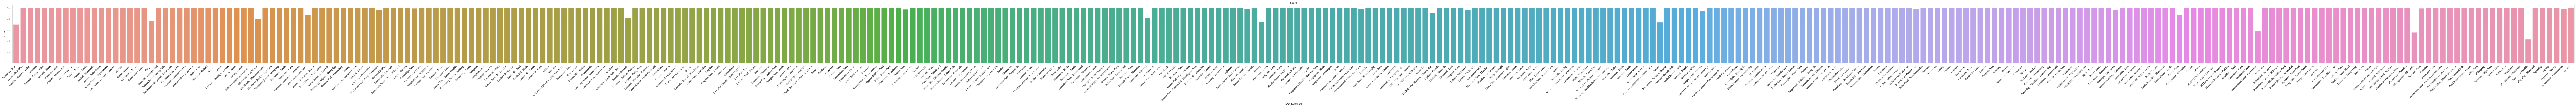

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Execute SQL query and retrieve results into a DataFrame
df = pd.read_sql_query("""
SELECT c."SA2_NAME21", 1/(1+ EXP(-1*(r.z_score + h.z_score + s.z_score + p.z_score + c.z_score))) as score
FROM school_z_score c join  poll_z_score p using ("SA2_NAME21") join  stop_z_score s using ("SA2_NAME21") join  health_z_score h using ("SA2_NAME21") join retail_z_score r using ("SA2_NAME21") """
, conn)

# Plot the columns
sns.set(style="whitegrid")  # Set the style of the plot

# Plotting the score column
plt.figure(figsize=(200, 10))  # Set the figure size
plt.subplot(2, 1, 1)  # Create a subplot for the first column
plt.title('Score')  # Set the title
plt.xticks(rotation=45, ha='right')
sns.barplot(data=df, x='SA2_NAME21', y='score')  # Create the bar plot


plt.show()  # Show the plot

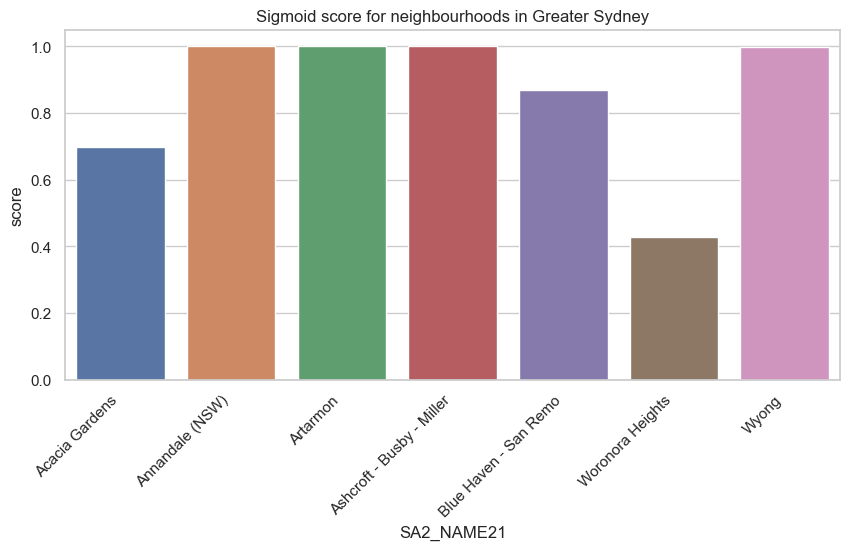

In [46]:
# Graph for specific examples for easy comparison
df = pd.read_sql_query("""
SELECT c."SA2_NAME21", 1/(1+ EXP(-1*(r.z_score + h.z_score + s.z_score + p.z_score + c.z_score))) as score
FROM school_z_score c join  poll_z_score p using ("SA2_NAME21") join  stop_z_score s using ("SA2_NAME21") join  health_z_score h using ("SA2_NAME21") join retail_z_score r using ("SA2_NAME21")
Where "SA2_NAME21" in ('Acacia Gardens', 'Annandale (NSW)', 'Blue Haven - San Remo',
'Artarmon', 'Ashcroft - Busby - Miller','Woronora Heights','Wyong')"""
, conn)

# Plot the columns
sns.set(style="whitegrid")  # Set the style of the plot

# Plotting the score column
plt.figure(figsize=(10, 10))  # Set the figure size
plt.subplot(2, 1, 1)  # Create a subplot for the first column
plt.title('Sigmoid score for neighbourhoods in Greater Sydney')  # Set the title
plt.xticks(rotation=45, ha='right')
sns.barplot(data=df, x='SA2_NAME21', y='score')  # Create the bar plot


plt.show()  # Show the plot

### Task 3

### Dataset 1 (Robbery Crime) - Spatial

In [47]:
robbery = gpd.read_file("CrimeToolHotspots_JanToDec21/Robbery_JanToDec2021.shp")
robbery['geom'] = robbery['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
robbery = robbery.drop(columns="geometry")
robbery

,OBJECTID,Contour,Density,ORIG_FID,Shape_Leng,Shape_Area,geom
0,1,8.0,Low Density,1,0.018407,0.000025,MULTIPOLYGON (((149.842514165 -36.677061464999...
1,2,8.0,Low Density,1,0.011175,0.000005,MULTIPOLYGON (((150.13795961000005 -36.2183840...
2,3,8.0,Low Density,1,0.010064,0.000005,MULTIPOLYGON (((149.1268528500001 -36.23182351...
3,4,8.0,Low Density,1,0.012074,0.000006,MULTIPOLYGON (((150.11838838000006 -36.2003833...
4,5,8.0,Low Density,1,0.026038,0.000037,MULTIPOLYGON (((150.11502347500004 -36.1633317...
...,...,...,...,...,...,...,...
1832,1833,10.0,High Density,3,0.008834,0.000003,MULTIPOLYGON (((153.28729724400011 -28.8087199...
1833,1834,10.0,High Density,3,0.039601,0.000055,MULTIPOLYGON (((153.27843877700002 -28.8064834...
1834,1835,10.0,High Density,3,0.018189,0.000008,MULTIPOLYGON (((153.61240236800006 -28.6435138...
1835,1836,10.0,High Density,3,0.011516,0.000006,MULTIPOLYGON (((153.53001569800006 -28.5127972...


In [48]:
conn.execute("""
DROP TABLE IF EXISTS robbery CASCADE;
CREATE TABLE robbery (
    "OBJECTID" INTEGER PRIMARY KEY,
    "Contour" NUMERIC,
    "Density" VARCHAR(16),
    "ORIG_FID" INTEGER, 
    "Shape_Leng" NUMERIC,
    "Shape_Area" NUMERIC,
    geom GEOMETRY(MULTIPOLYGON,4283)
);"""
)
robbery.to_sql('robbery', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, """select * from robbery """ )

,OBJECTID,Contour,Density,ORIG_FID,Shape_Leng,Shape_Area,geom
0,1,8.0,Low Density,1,0.018407,0.000025,0106000020BB1000000100000001030000000100000024...
1,2,8.0,Low Density,1,0.011175,0.000005,0106000020BB1000000100000001030000000100000012...
2,3,8.0,Low Density,1,0.010064,0.000005,0106000020BB100000010000000103000000010000000D...
3,4,8.0,Low Density,1,0.012074,0.000006,0106000020BB1000000100000001030000000100000016...
4,5,8.0,Low Density,1,0.026038,0.000037,0106000020BB1000000100000001030000000100000037...
...,...,...,...,...,...,...,...
1832,1833,10.0,High Density,3,0.008834,0.000003,0106000020BB100000010000000103000000010000000D...
1833,1834,10.0,High Density,3,0.039601,0.000055,0106000020BB1000000100000001030000000100000038...
1834,1835,10.0,High Density,3,0.018189,0.000008,0106000020BB100000010000000103000000010000001F...
1835,1836,10.0,High Density,3,0.011516,0.000006,0106000020BB1000000100000001030000000100000012...


In [49]:
sql = """ 
DROP VIEW IF EXISTS robbery_count CASCADE;
CREATE VIEW robbery_count AS
Select "SA2_NAME21", COALESCE(SUM("ORIG_FID"), 0) as c
FROM sa2 A JOIN population p on (sa2_code = "SA2_CODE21") left join robbery S ON ST_Contains(A.geom, S.geom)
where total_people >= 100 
group by "SA2_NAME21"
"""

sql2 = """ 
Select *
FROM robbery_count


"""

query(conn, sql)
query(conn, sql2)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,SA2_NAME21,c
0,Acacia Gardens,0
1,Annandale (NSW),0
2,Arncliffe - Bardwell Valley,2
3,Artarmon,6
4,Ashcroft - Busby - Miller,3
...,...,...
355,Wyoming,0
356,Wyong,8
357,Yagoona - Birrong,15
358,Yarramundi - Londonderry,0


In [50]:
sql = """ 
DROP VIEW IF EXISTS robbery_stats;
CREATE VIEW robbery_stats AS
Select  avg(c), stddev(c)
FROM robbery_count
"""

sql2 = """ 
Select *
FROM robbery_stats
"""

query(conn, sql)
query(conn, sql2)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,avg,stddev
0,3.216667,3.901682


In [51]:
sql = """
DROP VIEW IF EXISTS robbery_z_score;
CREATE VIEW  robbery_z_score AS
SELECT "SA2_NAME21", ((c-avg)/stddev) as z_score
FROM robbery_stats, robbery_count
"""
sql2 = """
SELECT *
from robbery_z_score"""
query(conn, sql)
query(conn, sql2)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,SA2_NAME21,z_score
0,Acacia Gardens,-0.824431
1,Annandale (NSW),-0.824431
2,Arncliffe - Bardwell Valley,-0.311831
3,Artarmon,0.713368
4,Ashcroft - Busby - Miller,-0.055532
...,...,...
355,Wyoming,-0.824431
356,Wyong,1.225967
357,Yagoona - Birrong,3.020065
358,Yarramundi - Londonderry,-0.824431


### Dataset 2 (Petrol Stations) - GeoJSON

In [52]:
pd.set_option('display.max_columns', None)
petrol = gpd.read_file("147635_00_0.geojson")

petrol = petrol[(petrol['STATION_STATE'] =='NSW')]
petrol['geom'] = petrol['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
petrol = petrol.drop(columns = ['STATION_ADDRESS','GNAF_SUBURB','GNAF_POSTCODE','DISTANCE_TO_GNAF','geometry','STATION_DESCRIPTION', 'INDUSTRY_ID','SPATIAL_CONFIDENCE','GNAF_ASSIGNMENT_METHOD','STATION_REVISED_DATE','GNAF_FORMATTED_ADDRESS','GNAF_ADDRESS_DETAIL_PID','GNAF_CONFIDENCE'])


conn.execute("""
DROP TABLE IF EXISTS petrol CASCADE;
CREATE TABLE petrol (
    "OBJECTID" INTEGER PRIMARY KEY,
    "FEATURE_TYPE" VARCHAR(50),
    "STATION_NAME" VARCHAR(50),
    "STATION_OWNER" VARCHAR(50),
    "STATION_SUBURB" VARCHAR(50),
    "STATION_POSTCODE" INTEGER, 
    "STATION_STATE" VARCHAR(3),
    "OPERATIONAL_STATUS" VARCHAR(15),
    geom GEOMETRY(POINT,4283)
);"""
)

petrol.to_sql('petrol', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, """
select * from petrol 
""" )

sql = """ 
DROP VIEW IF EXISTS petrol_count CASCADE;
CREATE VIEW petrol_count AS
Select "SA2_NAME21", COALESCE(COUNT("OBJECTID"), 0) as c
FROM sa2 A JOIN population p on (sa2_code = "SA2_CODE21")  left join petrol R ON ST_Contains(A.geom, R.geom)
where total_people >= 100 
group by "SA2_NAME21"
"""

sql2 = """ 
Select *
FROM petrol_count

"""

query(conn, sql)
query(conn, sql2)





Error encountered: 
This result object does not return rows. It has been closed automatically.


,SA2_NAME21,c
0,Acacia Gardens,0
1,Annandale (NSW),2
2,Arncliffe - Bardwell Valley,2
3,Artarmon,1
4,Ashcroft - Busby - Miller,1
...,...,...
355,Wyoming,4
356,Wyong,6
357,Yagoona - Birrong,6
358,Yarramundi - Londonderry,4


In [53]:
sql = """ 
DROP VIEW IF EXISTS petrol_stats;
CREATE VIEW petrol_stats AS
Select  avg(c), stddev(c)
FROM petrol_count
"""

sql2 = """ 
Select *
FROM petrol_stats
"""

query(conn, sql)
query(conn, sql2)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,avg,stddev
0,2.597222,2.104907


In [54]:
sql = """
DROP VIEW IF EXISTS petrol_z_score;
CREATE VIEW  petrol_z_score AS
SELECT "SA2_NAME21", ((c-avg)/stddev) as z_score
FROM petrol_stats, petrol_count
"""

sql2 = """SELECT *
from petrol_z_score"""

query(conn, sql)
query(conn, sql2)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,SA2_NAME21,z_score
0,Acacia Gardens,-1.233889
1,Annandale (NSW),-0.283729
2,Arncliffe - Bardwell Valley,-0.283729
3,Artarmon,-0.758809
4,Ashcroft - Busby - Miller,-0.758809
...,...,...
355,Wyoming,0.666432
356,Wyong,1.616593
357,Yagoona - Birrong,1.616593
358,Yarramundi - Londonderry,0.666432


In [55]:
sql = """
DROP VIEW IF EXISTS t3_score;
CREATE VIEW t3_score AS
SELECT c."SA2_NAME21", 1/(1+ EXP(-1*(r.z_score + h.z_score + s.z_score + p.z_score + c.z_score - ro.z_score + pt.z_score))) as score
FROM school_z_score c join  poll_z_score p using ("SA2_NAME21") join  stop_z_score s using ("SA2_NAME21") join  health_z_score h using ("SA2_NAME21") join retail_z_score r using ("SA2_NAME21") join robbery_z_score ro using ("SA2_NAME21") join petrol_z_score pt using ("SA2_NAME21") """

sql2 = """
select *
from t3_score
"""
query(conn, sql)
query(conn, sql2)

Error encountered: 
This result object does not return rows. It has been closed automatically.


,SA2_NAME21,score
0,Acacia Gardens,0.605209
1,Annandale (NSW),1.000000
2,Arncliffe - Bardwell Valley,1.000000
3,Artarmon,0.999954
4,Ashcroft - Busby - Miller,0.999964
...,...,...
355,Wyoming,0.999993
356,Wyong,0.999442
357,Yagoona - Birrong,1.000000
358,Yarramundi - Londonderry,0.996403


### Correlation Analysis

In [56]:
sql = """
SELECT CORR( median_income, score)
FROM income join score on ("SA2_NAME21" = sa2_name)
"""

query(conn, sql)

,corr
0,-0.006928


<Axes: xlabel='median_income', ylabel='score'>

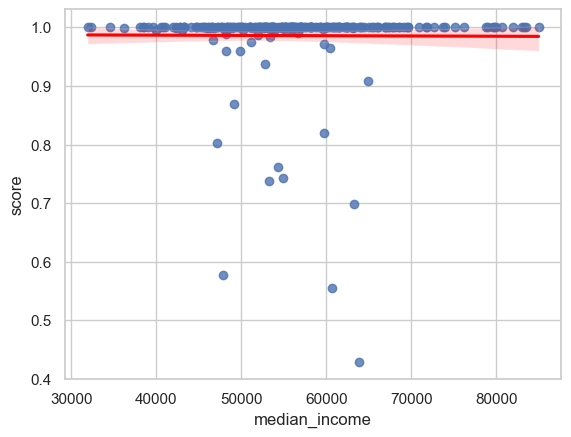

In [57]:
sql_query = pd.read_sql_query ('''
                               SELECT
                               *
                               FROM income join score on ("SA2_NAME21" = sa2_name)
                               ''', conn)

df = pd.DataFrame(sql_query, columns = ['SA2_NAME21', 'score', 'median_income'])
# print (df)
# sns.scatterplot( x= df["median_income"], y= df["score"]);
# plt.plot(X_plot, Y_plot, color='r')
sns.regplot(x= df["median_income"], y= df["score"], line_kws = {"color": "red"})
